# Mô hình ACO for VRP-DP(Base)

In [1]:
# Thư viện
import numpy as np
import pandas as pd
import random
import ast
import os
import matplotlib.pyplot as plt
from copy import deepcopy

## Load, xử lý dữ liệu và cài đặt tham số

In [2]:
# Load, xử lý dữ liệu và cài đặt tham số
# # Load dữ liệu
DATA_PATH = "vrpdp_dataset.csv"
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"The dataset file '{DATA_PATH}' was not found. Please ensure it exists in the working directory.")
df = pd.read_csv(DATA_PATH)

# Xử lý dữ liệu
df['PickupCoord'] = df['PickupCoord'].apply(ast.literal_eval)
df['DeliveryCoord'] = df['DeliveryCoord'].apply(ast.literal_eval)

nodes = [0] + sorted(set(df['PickupNode']).union(df['DeliveryNode']))
coords = {0: (40.0, 50.0)}
for _, row in df.iterrows():
    coords[row['PickupNode']] = row['PickupCoord']
    coords[row['DeliveryNode']] = row['DeliveryCoord']

def distance(a, b):
    return np.linalg.norm(np.array(a) - np.array(b))

n = len(nodes)
distance_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if i != j:
            distance_matrix[i][j] = distance(coords[nodes[i]], coords[nodes[j]])

# Thuật ngữ
pickup_nodes = list(df["PickupNode"])
delivery_nodes = list(df["DeliveryNode"])
demands = dict(zip(df["PickupNode"], df["Demand"]))

# Tham số mô hình
num_ants = 10
num_iterations = 20
num_vehicles = 3
alpha = 1.0
beta = 4.0
rho = 0.4
Q_pheromone = 800
vehicle_capacity = 100
pheromone = np.ones((n, n))

## Ý nghĩa các tham số

- alpha         : *pheromone có ảnh hưởng trung bình*
- beta          : *heuristic (khoảng cách) được ưu tiên hơn*
- rho           : *% pheromone sẽ bay hơi sau mỗi vòng*
- Q_pheromone   : *lượng pheromone sẽ rải trên cung tốt nhất*
- num_ants      : *số lượng xe/kiến xây dựng tuyến tối ưu cho mỗi vòng*
- num_iterations: *Số vòng thuật toán chạy tối đa*
- vehicle_capacity:  *tải trọng tối đa của 1 xe*
- num_vehicles  : số lượng xe của 1 depot

## Mô hình ACO-VRPDP(Base) với 1 xe

In [ ]:
# ACO-VRPDP(Base)  với 1 xe
best_route = None
best_cost = float('inf')
for iteration in range(num_iterations):
    for ant in range(num_ants):
        route = [0]
        load = 0
        current_node = 0
        unvisited_pickups = set(pickup_nodes)
        unvisited_deliveries = set(delivery_nodes)
        visited_pickups = set()

        while unvisited_pickups or unvisited_deliveries:
            candidates = []
            for j in unvisited_pickups.union(unvisited_deliveries):
                if j in unvisited_pickups and load + demands[j] <= vehicle_capacity:
                    candidates.append(j)
                elif j in unvisited_deliveries:
                    pickup_j = df[df["DeliveryNode"] == j]["PickupNode"].values[0]
                    if pickup_j not in unvisited_pickups:
                        candidates.append(j)

            if not candidates:
                break

            probs = []
            for j in candidates:
                i_idx = nodes.index(current_node)
                j_idx = nodes.index(j)
                tau = pheromone[i_idx][j_idx] ** alpha
                eta = (1.0 / distance_matrix[i_idx][j_idx]) ** beta
                probs.append(tau * eta)

            total = sum(probs)
            probs = [p / total for p in probs]
            next_node = random.choices(candidates, weights=probs, k=1)[0]
            route.append(next_node)

            if next_node in unvisited_pickups:
                load += demands[next_node]
                unvisited_pickups.remove(next_node)
                visited_pickups.add(next_node)  # ✅ Lưu lại rằng pickup này đã xong
            elif next_node in unvisited_deliveries:
                pickup_node = df[df["DeliveryNode"] == next_node]["PickupNode"].values[0]
                if pickup_node in visited_pickups:  # ✅ Chỉ được giao hàng nếu đã lấy
                    load -= demands[pickup_node]
                    unvisited_deliveries.remove(next_node)
                else:
					# 🚫 Nếu gặp delivery trước pickup → bỏ qua lần chọn này
                    continue

            current_node = next_node

        route.append(0)
        cost = sum(distance_matrix[nodes.index(route[i])][nodes.index(route[i + 1])]
                   for i in range(len(route) - 1))

        if cost < best_cost:
            best_cost = cost
            best_route = route

    pheromone *= (1 - rho)
    for i in range(len(best_route) - 1):
        a, b = nodes.index(best_route[i]), nodes.index(best_route[i + 1])
        pheromone[a][b] += Q_pheromone / best_cost

print("\n Tuyến đường tối ưu:")
print(" → ".join(str(node) for node in best_route))
print(f"Tổng chi phí: {round(best_cost, 2)}")



 Tuyến đường tối ưu:
0 → 44 → 42 → 45 → 47 → 49 → 58 → 56 → 59 → 65 → 88 → 87 → 84 → 90 → 89 → 99 → 98 → 100 → 3 → 7 → 10 → 12 → 18 → 17 → 15 → 35 → 36 → 70 → 75 → 73 → 61 → 60 → 78 → 74 → 77 → 79 → 67 → 46 → 29 → 24 → 14 → 8 → 76 → 0
Tổng chi phí: 588.81


In [4]:
def check_load_constraints(route, pickup_to_demand, delivery_to_pickup, vehicle_capacity):
    load = 0
    active_pickups = set()
    used_deliveries = set()
    loads = []

    for idx, node in enumerate(route):
        if node == 0:
            # Depot, reset load (nếu muốn) hoặc giữ nguyên
            loads.append(load)
            continue

        if node in pickup_to_demand:
            demand = pickup_to_demand[node]
            load += demand
            active_pickups.add(node)

        elif node in delivery_to_pickup:
            pickup_node = delivery_to_pickup[node]

            if node in used_deliveries:
                return False, loads, f"Lỗi tại vị trí {idx}: đơn hàng giao {node} đã được giao trước đó"

            if pickup_node not in active_pickups:
                return False, loads, f"Lỗi tại vị trí {idx}: giao hàng {node} trước khi lấy hàng {pickup_node}"

            load -= pickup_to_demand[pickup_node]
            used_deliveries.add(node)

        else:
            return False, loads, f"Lỗi tại vị trí {idx}: node {node} không xác định pickup hay delivery"

        if load < 0:
            return False, loads, f"Lỗi tại vị trí {idx}: tải trọng âm tại node {node} (load={load})"
        if load > vehicle_capacity:
            return False, loads, f"Lỗi tại vị trí {idx}: vượt tải tại node {node} (load={load})"

        loads.append(load)

    return True, loads, "✅ Ràng buộc tải trọng hợp lệ"


In [5]:
# Hàm vẽ biểu đồ tải trọng
import matplotlib.pyplot as plt
def plot_pickup_delivery(route, load_profile, pickup_nodes, delivery_nodes):
    steps = list(range(len(route)))
    pickup_steps = [i for i, node in enumerate(route) if node in pickup_nodes]
    delivery_steps = [i for i, node in enumerate(route) if node in delivery_nodes]
    plt.figure(figsize=(12, 6))
    plt.plot(steps, load_profile, color='gray', linestyle='--', label='Tải trọng tổng thể')
    plt.scatter([steps[i] for i in pickup_steps], [load_profile[i] for i in pickup_steps],
                color='blue', label='Pickup', marker='^', s=100)
    plt.scatter([steps[i] for i in delivery_steps], [load_profile[i] for i in delivery_steps],
                color='orange', label='Delivery', marker='v', s=100)
    for i, load in enumerate(load_profile):
        plt.text(steps[i], load + 2, f"{load}", fontsize=7, ha='center')
    plt.xticks(steps, [str(node) for node in route], rotation=90)
    plt.xlabel("Các điểm trong tuyến đường")
    plt.ylabel("Tải trọng (units)")
    plt.title("Biểu đồ Tải trọng - Phân biệt Pickup và Delivery")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


✅ Ràng buộc tải trọng hợp lệ


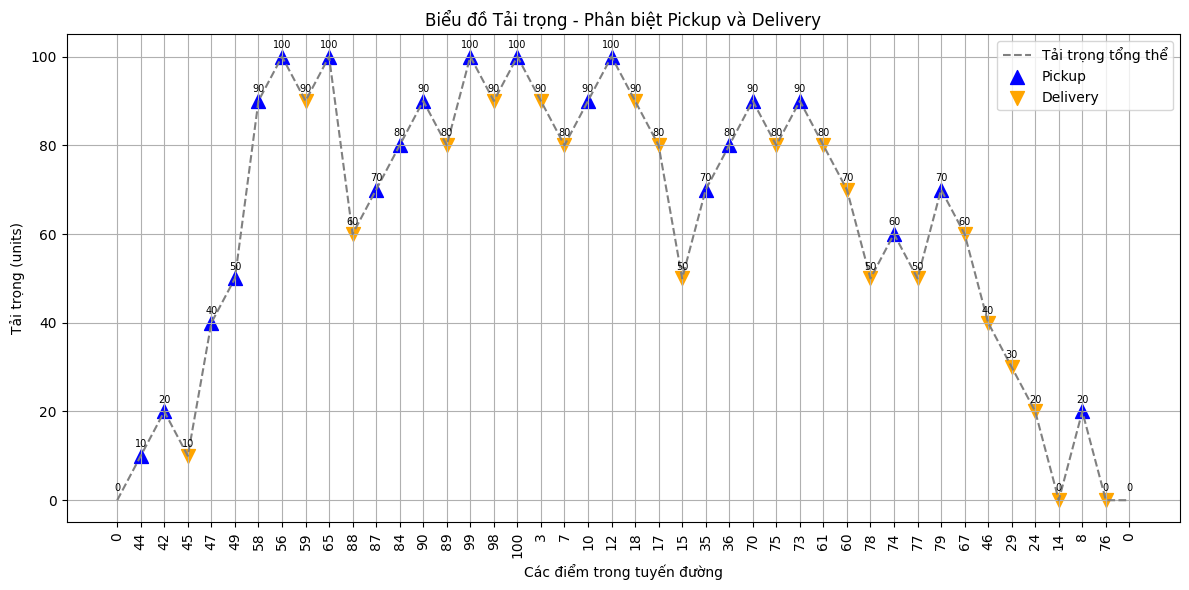

In [6]:
# Gọi hàm kiểm tra và vẽ biểu đồ
pickup_to_demand = {p: d for p, d in zip(df['PickupNode'], df['Demand'])}
delivery_to_pickup = {d: p for p, d in zip(df['PickupNode'], df['DeliveryNode'])}
is_valid, load_profile, message = check_load_constraints(best_route, pickup_to_demand, delivery_to_pickup, vehicle_capacity)
print(message)
if is_valid:
    plot_pickup_delivery(best_route, load_profile, pickup_nodes, delivery_nodes)

Vòng lặp: 10, Chi phí tốt nhất: 585.0
Vòng lặp: 20, Chi phí tốt nhất: 578.21
Vòng lặp: 30, Chi phí tốt nhất: 606.3
Vòng lặp: 40, Chi phí tốt nhất: 578.69


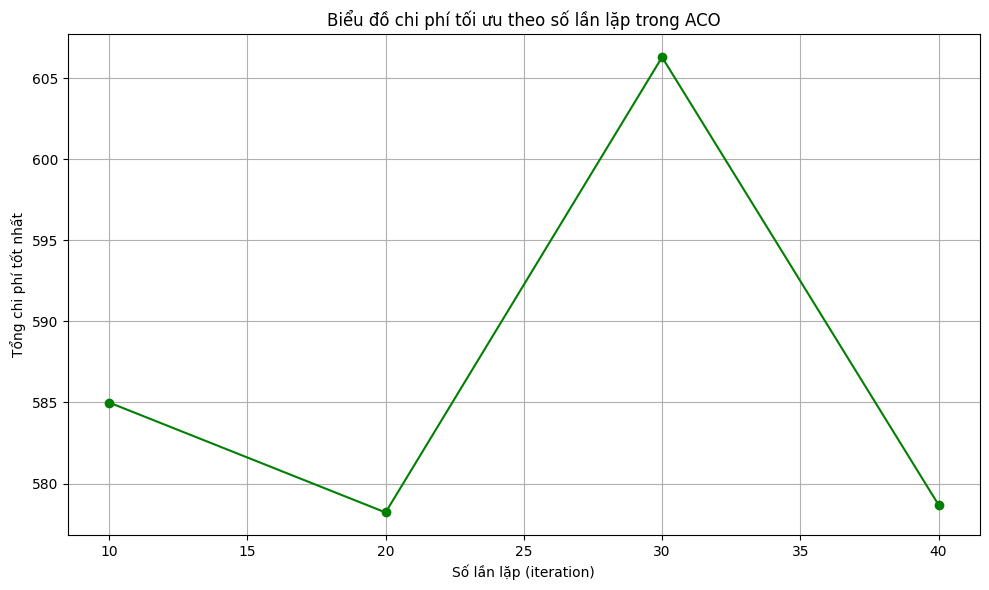

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import random

iteration_tests = list(range(10, 50, 10))  # 10, 20, ..., 100
costs_per_iteration = []

for num_iterations in iteration_tests:
    pheromone = np.ones((n, n))  # reset pheromone mỗi lần
    best_cost = np.inf
    best_route = []

    for iteration in range(num_iterations):
        for ant in range(num_ants):
            route = [0]
            load = 0
            current_node = 0
            unvisited_pickups = set(pickup_nodes)
            unvisited_deliveries = set(delivery_nodes)
            visited_pickups = set()
            

            while unvisited_pickups or unvisited_deliveries:
                candidates = []
                for j in unvisited_pickups.union(unvisited_deliveries):
                    if j in unvisited_pickups and load + demands[j] <= vehicle_capacity:
                        candidates.append(j)
                    elif j in unvisited_deliveries:
                        pickup_j = df[df["DeliveryNode"] == j]["PickupNode"].values[0]
                        if pickup_j not in unvisited_pickups:
                            candidates.append(j)

                if not candidates:
                    break

                probs = []
                for j in candidates:
                    i_idx = nodes.index(current_node)
                    j_idx = nodes.index(j)
                    tau = pheromone[i_idx][j_idx] ** alpha
                    eta = (1.0 / distance_matrix[i_idx][j_idx]) ** beta
                    probs.append(tau * eta)

                total = sum(probs)
                probs = [p / total for p in probs]
                next_node = random.choices(candidates, weights=probs, k=1)[0]
                route.append(next_node)

                if next_node in unvisited_pickups:
                    load += demands[next_node]
                    unvisited_pickups.remove(next_node)
                    visited_pickups.add(next_node)  # ✅ Lưu lại rằng pickup này đã xong
                elif next_node in unvisited_deliveries:
                    pickup_node = df[df["DeliveryNode"] == next_node]["PickupNode"].values[0]
                    if pickup_node in visited_pickups:  # ✅ Chỉ được giao hàng nếu đã lấy
                        load -= demands[pickup_node]
                        unvisited_deliveries.remove(next_node)
                    else:
					# 🚫 Nếu gặp delivery trước pickup → bỏ qua lần chọn này
                        continue

                current_node = next_node

            route.append(0)
            cost = sum(distance_matrix[nodes.index(route[i])][nodes.index(route[i + 1])]
                       for i in range(len(route) - 1))

            if cost < best_cost:
                best_cost = cost
                best_route = route

        pheromone *= (1 - rho)
        for i in range(len(best_route) - 1):
            a, b = nodes.index(best_route[i]), nodes.index(best_route[i + 1])
            pheromone[a][b] += Q_pheromone / best_cost

    costs_per_iteration.append(best_cost)
    print(f"Vòng lặp: {num_iterations}, Chi phí tốt nhất: {round(best_cost, 2)}")

# Vẽ biểu đồ tổng chi phí theo số lần lặp
plt.figure(figsize=(10,6))
plt.plot(iteration_tests, costs_per_iteration, marker='o', color='green')
plt.xlabel("Số lần lặp (iteration)")
plt.ylabel("Tổng chi phí tốt nhất")
plt.title("Biểu đồ chi phí tối ưu theo số lần lặp trong ACO")
plt.grid(True)
plt.tight_layout()
plt.show()

## Mô hình ACO-VRPDP(Base) với 3 xe

In [8]:
# Mô hình ACO-VRPDP(Base) với 3 xe
best_solution = None
best_cost = float("inf")

# Hàm xây dựng lời giải gồm nhiều tuyến (mỗi tuyến là của 1 xe)
def build_solution():
    unvisited_pickups = set(pickup_nodes)
    unvisited_deliveries = set(delivery_nodes)
    routes = [[] for _ in range(num_vehicles)]
    loads = [0] * num_vehicles
    positions = [0] * num_vehicles
    visited_pickups = [set() for _ in range(num_vehicles)]  # theo dõi pickup của từng xe

    while unvisited_pickups or unvisited_deliveries:
        updated = False
        for v in range(num_vehicles):
            candidates = []
            for j in unvisited_pickups.union(unvisited_deliveries):
                if j in unvisited_pickups and loads[v] + demands[j] <= vehicle_capacity:
                    candidates.append(j)
                elif j in unvisited_deliveries:
                    pickup_j = df[df["DeliveryNode"] == j]["PickupNode"].values[0]
                    if pickup_j not in unvisited_pickups and pickup_j in visited_pickups[v]:
                        candidates.append(j)

            if not candidates:
                continue

            # Tính xác suất ACO kết hợp khoảng cách heuristic 
            i_idx = nodes.index(positions[v])
            tau_eta_d = []
            for j in candidates:
                j_idx = nodes.index(j)
                tau = pheromone[i_idx][j_idx] ** alpha
                eta = (1.0 / distance_matrix[i_idx][j_idx]) ** beta
                # heuristic bổ sung: khoảng cách hiện tại → gần thì ưu tiên -> một dạng soft greedy
                greedy_factor = 1 / (distance_matrix[i_idx][j_idx] + 1e-6)  # tránh chia 0
                tau_eta_d.append(tau * eta * greedy_factor)

            total = sum(tau_eta_d)
            probs = [p / total for p in tau_eta_d]
            next_node = random.choices(candidates, weights=probs, k=1)[0]

            routes[v].append(next_node)
            positions[v] = next_node
            updated = True

            if next_node in unvisited_pickups:
                loads[v] += demands[next_node]
                unvisited_pickups.remove(next_node)
                visited_pickups[v].add(next_node)
            elif next_node in unvisited_deliveries:
                pickup_node = df[df["DeliveryNode"] == next_node]["PickupNode"].values[0]
                loads[v] -= demands[pickup_node]
                unvisited_deliveries.remove(next_node)

        if not updated:
            break

    full_routes = [[0] + r + [0] if len(r) > 0 else [0, 0] for r in routes]
    return full_routes

# Tính tổng chi phí cho lời giải
def total_cost(routes):
    cost = 0
    for route in routes:
        for i in range(len(route) - 1):
            a, b = nodes.index(route[i]), nodes.index(route[i + 1])
            cost += distance_matrix[a][b]
    return cost

# Vòng lặp chính ACO
for iteration in range(num_iterations):
    for ant in range(num_ants):
        routes = build_solution()
        cost = total_cost(routes)
        if cost < best_cost:
            best_cost = cost
            best_solution = routes
    pheromone *= (1 - rho)
    for route in best_solution:
        for i in range(len(route) - 1):
            a, b = nodes.index(route[i]), nodes.index(route[i + 1])
            pheromone[a][b] += Q_pheromone / best_cost

# Output
print("Tổng chi phí tối ưu cho cả 3 xe khi chạy mô hình ACO-VRPDP(Base):", round(best_cost, 2))
for i, route in enumerate(best_solution):
    print(f"Tuyến xe {i+1}:", " → ".join(map(str, route)))

Tổng chi phí tối ưu cho cả 3 xe khi chạy mô hình ACO-VRPDP(Base): 890.72
Tuyến xe 1: 0 → 44 → 45 → 47 → 49 → 59 → 58 → 88 → 90 → 7 → 10 → 15 → 17 → 0
Tuyến xe 2: 0 → 70 → 73 → 75 → 65 → 42 → 56 → 36 → 35 → 29 → 24 → 12 → 14 → 18 → 61 → 77 → 89 → 0
Tuyến xe 3: 0 → 8 → 76 → 99 → 100 → 87 → 84 → 79 → 78 → 74 → 67 → 46 → 60 → 3 → 98 → 0


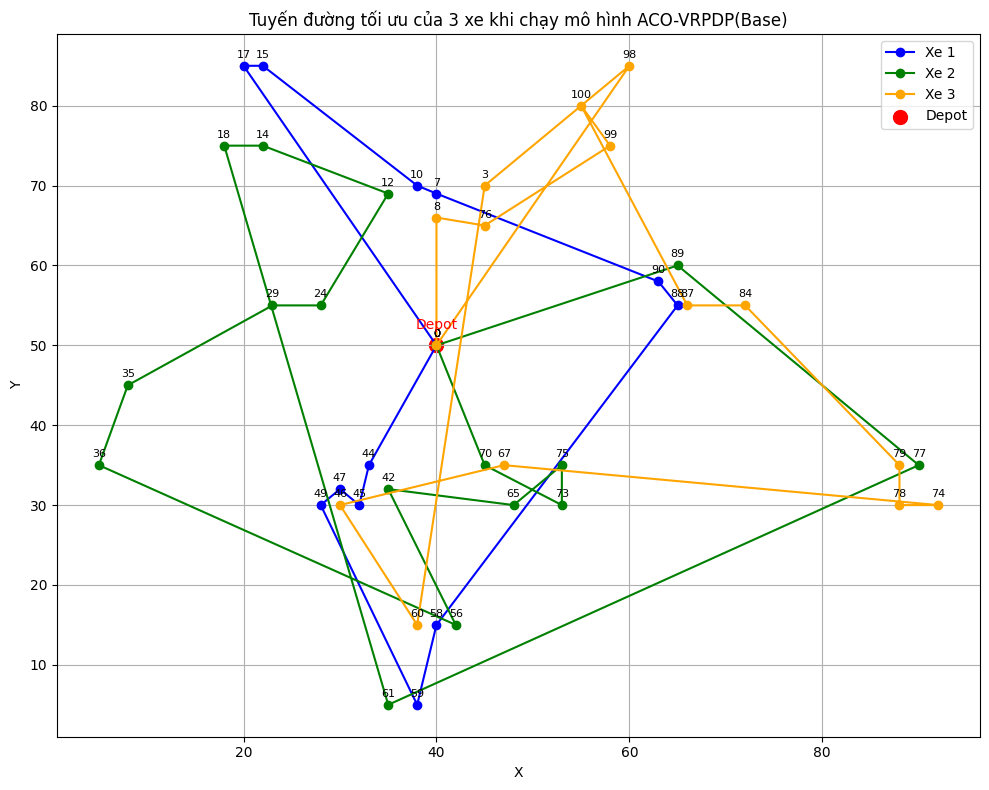

In [9]:

# Vẽ tuyến đường của mỗi xe
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'orange', 'purple', 'cyan']
for i, route in enumerate(best_solution):
    x_vals = [coords[n][0] for n in route]
    y_vals = [coords[n][1] for n in route]
    plt.plot(x_vals, y_vals, marker='o', label=f"Xe {i+1}", color=colors[i % len(colors)])
    for n in route:
        plt.text(coords[n][0], coords[n][1]+1, str(n), fontsize=8, ha='center')
plt.scatter(coords[0][0], coords[0][1], color='red', s=100, label='Depot')
plt.text(coords[0][0], coords[0][1]+2, 'Depot', color='red', fontsize=10, ha='center')
plt.title("Tuyến đường tối ưu của 3 xe khi chạy mô hình ACO-VRPDP(Base)")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
